In [31]:
import cv2 as cv
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D

from matplotlib.image import imread
import matplotlib.pyplot as plt
import random

from resnet50 import ResNet50

In [2]:
# File Directory for both the train and test
train_path = "./data/chest-ctscan-images/train"
val_path = "./data/chest-ctscan-images/valid"
test_path = "./data/chest-ctscan-images/test"

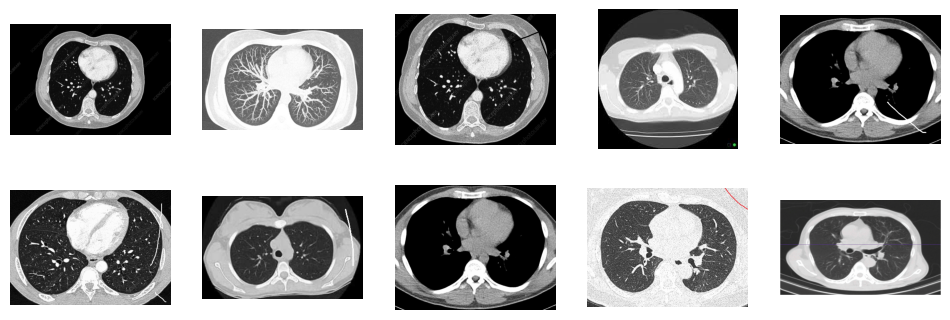

In [3]:
def visualize_images(folder_path):
    image_files = os.listdir(folder_path)
    fig, ax = plt.subplots(2,5, figsize=(12,4))
    
    for i in range(2):
        for j in range(5):
            img_path = os.path.join(folder_path, random.choice(image_files))
            image = imread(img_path)
            ax[i, j].imshow(image, cmap="gray")
            ax[i, j].axis('off')
    
    plt.show()

folder_path = train_path + '/normal'
visualize_images(folder_path)

## Image augmentation

In [4]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   preprocessing_function=preprocess_input,
                                   dtype="float32")

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

In [5]:
train_data = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical")
val_data = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode="categorical")

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [6]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

#  Resnet model

In [15]:
resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_106 (Conv2D)         (None, 112, 112, 64)         9472      ['zero_padding2d_2[0][0]']    
                                                                                                  
 batch_normalization_108 (B  (None, 112, 112, 64)         256       ['conv2d_106[0][0]']    

 batch_normalization_116 (B  (None, 55, 55, 64)           256       ['conv2d_114[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_105 (Activation  (None, 55, 55, 64)           0         ['batch_normalization_116[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_115 (Conv2D)         (None, 55, 55, 64)           36928     ['activation_105[0][0]']      
                                                                                                  
 batch_normalization_117 (B  (None, 55, 55, 64)           256       ['conv2d_115[0][0]']          
 atchNormalization)                                                                               
          

                                                                     'activation_110[0][0]']      
                                                                                                  
 activation_113 (Activation  (None, 28, 28, 512)          0         ['add_36[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_124 (Conv2D)         (None, 28, 28, 128)          65664     ['activation_113[0][0]']      
                                                                                                  
 batch_normalization_126 (B  (None, 28, 28, 128)          512       ['conv2d_124[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_135 (B  (None, 14, 14, 1024)         4096      ['conv2d_133[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 add_39 (Add)                (None, 14, 14, 1024)         0         ['batch_normalization_134[0][0
                                                                    ]',                           
                                                                     'batch_normalization_135[0][0
                                                                    ]']                           
                                                                                                  
 activation_122 (Activation  (None, 14, 14, 1024)         0         ['add_39[0][0]']              
 )        

                                                                                                  
 conv2d_142 (Conv2D)         (None, 14, 14, 1024)         263168    ['activation_130[0][0]']      
                                                                                                  
 batch_normalization_144 (B  (None, 14, 14, 1024)         4096      ['conv2d_142[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 add_42 (Add)                (None, 14, 14, 1024)         0         ['batch_normalization_144[0][0
                                                                    ]',                           
                                                                     'activation_128[0][0]']      
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_151 (Conv2D)         (None, 7, 7, 2048)           1050624   ['activation_139[0][0]']      
                                                                                                  
 conv2d_152 (Conv2D)         (None, 7, 7, 2048)           2099200   ['activation_137[0][0]']      
                                                                                                  
 batch_normalization_153 (B  (None, 7, 7, 2048)           8192      ['conv2d_151[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_154 (B  (None, 7, 7, 2048)           8192      ['conv2d_152[0][0]']          
 atchNorma

## transfer learning

In [16]:
for layer in resnet.layers:
    layer.trainable = False
    
model = Sequential()
model.add(resnet)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_161 (B  (None, 7, 7, 2048)        8192      
 atchNormalization)                                              
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 2048)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 3, 3, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)             

## compiling the model

In [17]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

## training the model

In [18]:
mc1 = ModelCheckpoint(
    filepath="ct_resnet_best_model.hdf5",
    monitor="val_accuracy",
    save_best_only="True",
    mode = 'max',)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               restore_best_weights = True)
#Defining LR Reducing rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                             factor = 0.1,
                             patience = 5,
                             verbose = 1,
                             min_delta = 0.8)

history = model.fit(train_data,
                    validation_data=val_data,
                    epochs = 50,
                    batch_size=32,
                    callbacks=[mc1, early_stopping]
                   )

Epoch 1/50
20/20 [==============================] - 81s 4s/step - loss: 4.2308 - accuracy: 0.4062 - val_loss: 4.7557 - val_accuracy: 0.4306
Epoch 2/50
20/20 [==============================] - 70s 3s/step - loss: 2.7414 - accuracy: 0.5204 - val_loss: 1.4242 - val_accuracy: 0.4722
Epoch 3/50
20/20 [==============================] - 69s 3s/step - loss: 1.8275 - accuracy: 0.5220 - val_loss: 0.9504 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 65s 3s/step - loss: 1.2418 - accuracy: 0.5563 - val_loss: 0.9965 - val_accuracy: 0.5000
Epoch 5/50
20/20 [==============================] - 68s 3s/step - loss: 1.1048 - accuracy: 0.5726 - val_loss: 0.9568 - val_accuracy: 0.5417
Epoch 6/50
20/20 [==============================] - 66s 3s/step - loss: 1.0970 - accuracy: 0.5693 - val_loss: 0.9054 - val_accuracy: 0.5417
Epoch 7/50
20/20 [==============================] - 67s 3s/step - loss: 0.9170 - accuracy: 0.6313 - val_loss: 0.7863 - val_accuracy: 0.6806
Epoch 8/50
20/20 [==

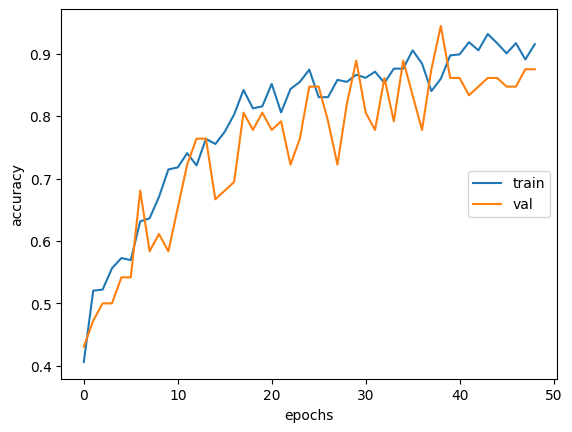

In [19]:
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val")
plt.legend(loc="right")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# test 

In [24]:
saved_model = load_model("ct_resnet_best_model.hdf5")

In [30]:
score = saved_model.evaluate(test_data, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 [==============================] - 15s 1s/step - loss: 0.5754 - accuracy: 0.7810
Test loss: 0.5753685235977173
Test accuracy: 0.7809523940086365
